# Pathway Analysis

Pathway Analysis refers to the set of tools and techniques used to assess data collected from high-throughput technologies, with the aim of discovering meaningful group of genes that are altered in case samples when compared to a control. BY measuring gene expression changes in a pathway, Pathway Analysis methods attempt to derive insight from lists of genes obtained from Differential Expression analyses. Pathway Enrichment Analysis helps identify Biological pathways enriched in a genelist more than would be expected by chance.
In this module, Pathway Analysis methods including Over Representation Analysis (ORA), Fast Gene Set Enrichment Analysis (FGSEA) and GSA are explained.

In ORA, for each pathway of interest, several statistical tests are used to test the pathways for over-representation in the gene list compared to what would be expected by chance, and these consider the number of genes detected in the experiment and their relative ranking as well as the  number of genes annotated to a pathway of interest. ORA obtains the statistical significance of the overlap between the number of similar genes shared by an input gene set and each annotated gene set via statistical tests and uses a p-value cutoff to identify annotated gene sets with significant overlaps to the input gene set.
Gene Set Enrichment Analysis (GSEA) avoids the need for an ad hoc cutoff (e.g. expression fold change) in identifying the input gene set by ranking all genes in the genome by differential expression level and then checks if any annotated gene set is scored unexpectedly high or low.



## Learning Objectives:
1. Introduction to enrichment analysis,
2. Performing Enrichment analysis using different methods,
3. Visualizing the outputs,
4. Saving results.

## Enrichment analysis
 Gene Set Enrichment Analysis methods help gain insight into obtained gene lists by identifying pathways that are enriched in a gene list more than would be expected by chance. The three major steps involved the process include; definition of a gene list from omics data, determination of statistically enriched pathways, and visualization and interpretation of the results.

### Loading and mapping DE genes

In [58]:
data <- readRDS("./data/DE_genes.rds")
rownames(data) <- data$PROBEID
head(data)

,PROBEID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,222178_s_at,-0.4473780,0.3653633,-73.01106,4.019112e-55,2.197450e-50,81.05538
224687_at,224687_at,-4.1431631,2.2572347,-48.92036,5.489424e-46,1.500671e-41,74.18354
207488_at,207488_at,-0.4017530,0.6243144,-39.29933,4.735684e-41,8.630785e-37,68.83493
239226_at,239226_at,0.4483302,1.3245501,28.36499,7.626558e-34,1.042455e-29,58.84908
234109_x_at,234109_x_at,-0.2289726,0.7508256,-27.67010,2.635337e-33,2.881741e-29,58.00438
212833_at,212833_at,-2.5976592,1.7308944,-24.01172,2.914912e-30,2.656213e-26,52.99567


In [4]:
# Loading needed libraries

In [5]:
suppressMessages({
  library(hgu133plus2.db)
  library(AnnotationDbi)
})

In [6]:
# We will then obtain the probe IDs and map them to the Gene name and Gene Symbol

In [59]:
probeIDs = data$PROBEID

In [60]:
suppressMessages({
annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID','GENENAME','SYMBOL'))
})

In [61]:
head(annotLookup)

,PROBEID,GENENAME,SYMBOL
,<chr>,<chr>,<chr>
1,222178_s_at,NA,NA
2,224687_at,ankyrin repeat and IBR domain containing 1,ANKIB1
3,207488_at,NA,NA
4,239226_at,NA,NA
5,234109_x_at,one cut homeobox 3,ONECUT3
6,212833_at,solute carrier family 25 member 46,SLC25A46


In [62]:
# Merge DE result  data frame with annotation table
data = merge(annotLookup, data, by="PROBEID")

In [63]:
head(data)

,PROBEID,GENENAME,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1007_s_at,discoidin domain receptor tyrosine kinase 1,DDR1,-0.23858465,1.0967772,-2.08257585,0.04210211,0.2531265,-4.284228
2,1053_at,replication factor C subunit 2,RFC2,0.05830367,0.9657758,1.42311356,0.16052793,0.4674726,-5.359907
3,117_at,heat shock protein family A (Hsp70) member 6,HSPA6,-0.01138494,1.1501582,-0.08100885,0.93573821,0.9861536,-6.337785
4,121_at,paired box 8,PAX8,0.02301084,1.0581847,0.87166663,0.38729816,0.7236528,-5.968512
5,1255_g_at,guanylate cyclase activator 1A,GUCA1A,0.36999950,1.4080351,1.78615022,0.07976123,0.3351480,-4.812134
6,1294_at,ubiquitin like modifier activating enzyme 7,UBA7,-0.11221434,1.0859983,-1.61593670,0.11200995,0.3925252,-5.082923


### Enrichment analysis using ORA
Over-representation (or enrichment) analysis is a statistical method that determines whether genes from pre-defined sets (ex: those belonging to a specific GO term or KEGG pathway) are present more than would be expected (over-represented) in a subset of your data. The p-value can be calculated by hyper-geometric distribution and it is given by:



![images/Module4/ora_p_value.png](images/Module4/ora_p_value.png)

where N is the total number of genes in the background distribution, M is the number of genes within that distribution that are annotated (either directly or indirectly) to the gene set of interest, n is the size of the list of genes of interest and k is the number of genes within that list which are annotated to the gene set. The background distribution by default is all the genes that have annotation.

### Over Representation Analysis Using GO and KEGG
Getting the DE genes from  `limma` result

In [64]:
# Getting a list of DE genes
DEGenes <- data[!is.na(data$adj.P.Val) & data$adj.P.Val <= 0.05,]
# Select gene symbol
DEGenes <- DEGenes$SYMBOL
# Remove gene with NA symbol
DEGenes <- na.omit(DEGenes)
# Remove duplicated genes
DEGenes <- unique(DEGenes)


In [65]:
#Defining background set
backgroundSet <- data$SYMBOL
backgroundSet <- na.omit(backgroundSet)
backgroundSet <- unique(backgroundSet)


In [66]:
suppressMessages({
  library(tidyverse)
})

In [67]:
gmt2geneset <- function(path){
  genesets <- read_tsv(path, col_names = F) %>% apply(MARGIN = 1, function(r){
    genes = unique(r[-(1:2)])
    list(
      id = r[1],
      description = r[2],
      genes = genes[!is.na(genes)]
    )
  })

  gs <- lapply(genesets, function(g) g$genes %>% as.character())
  names(gs) <- lapply(genesets, function(g) g$id)
  gs
}

In [68]:
suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})

Warning message:
"One or more parsing issues, see `problems()` for details"


Perform over-representation analysis

In [69]:
res <- sapply(geneset, function(gs){
  # hypergeomestric test
  wBallDraw <- intersect(gs, DEGenes) %>%  length() - 1
  if (wBallDraw < 0) return(1)
  wBall <- length(DEGenes)
  bBall <- nrow(data) - length(DEGenes)
  ballDraw <- length(intersect(gs, backgroundSet))
  1 - phyper(wBallDraw, wBall, bBall, ballDraw)
})

In [19]:
res.df <- data.frame(
  pathway = names(res),
  pvalue = res
)

In [20]:
res.df$pvalue.adj <- p.adjust(res.df$pvalue, method = "fdr")
res.df <- res.df[order(!res.df$pvalue.adj),]
head(res.df)

,pathway,pvalue,pvalue.adj
,<chr>,<dbl>,<dbl>
GO:0000002,GO:0000002,0.2784128,0.5787196
GO:0000003,GO:0000003,0.2714523,0.5676719
GO:0000012,GO:0000012,1.0000000,1.0000000
GO:0000018,GO:0000018,0.2714523,0.5676719
GO:0000027,GO:0000027,1.0000000,1.0000000
GO:0000028,GO:0000028,1.0000000,1.0000000


### ORA With KEGG Data

In [22]:
suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})

Warning message:
"One or more parsing issues, see `problems()` for details"


In [24]:
res <- sapply(geneset, function(gs){
  # hypergeomestric test
  wBallDraw <- intersect(gs, DEGenes) %>%  length() - 1
  if (wBallDraw < 0) return(1)
  wBall <- length(DEGenes)
  bBall <- nrow(data) - length(DEGenes)
  ballDraw <- length(intersect(gs, backgroundSet))
  1 - phyper(wBallDraw, wBall, bBall, ballDraw)
})

res.df <- data.frame(
  pathway = names(res),
  pvalue = res
)

res.df$pvalue.adj <- p.adjust(res.df$pvalue, method = "fdr")
res.df <- res.df[order(!res.df$pvalue.adj),]
head(res.df)

,pathway,pvalue,pvalue.adj
,<chr>,<dbl>,<dbl>
hsa00010,hsa00010,0.003514458,0.03722398
hsa00020,hsa00020,0.033191479,0.15959191
hsa00030,hsa00030,0.033191479,0.15959191
hsa00040,hsa00040,0.257329575,0.61864850
hsa00051,hsa00051,0.003817844,0.03722398
hsa00052,hsa00052,0.257329575,0.61864850


## Enrichment Analysis using FGSEA


This submodule describes FGSEA, one of the methods for evaluating pathway enrichment in transcriptional data and it stands for Fast preranked Gene Set Enrichment Analysis (GSEA). FGSEA quickly calculates arbitrarily low GSEA P-values for a collection of gene sets and is based on an algorithm that allows  it to make more permutations and get accurate p-values.
It extends the GSEA algorithm which Calculates the Enrichment Score (the degree to which a set S is over-represented at the top or bottom of the ranked list L), estimates the p-value of the Enrichment Score using a permutation test and adjusts the estimated significance level to account for multiple hypothesis in addition to calculating the q-values for FDR control.

The FGSEA method call is given by:

fgseaRes <- fgsea(pathways = examplePathways,
                  stats    = exampleRanks,
                  minSize  = 15,
                  maxSize  = 500)

where:
+ pathways = a list of gene sets to check,
+ stats    = a named vector of gene-level statistics, where the names should be the same as the gene names in the pathways list,
+ minSize and maxSize are the minimum and maximum number of pathways of interest.

And the output is a table containing enrichment scores and p-values.



In [25]:
# To run FGSEA Enrichment Analysis, we first install the fgsea package
suppressMessages({if (!require("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
  suppressWarnings(BiocManager::install("fgsea", update = F))
})

In [26]:
# Loading the package
suppressPackageStartupMessages({
  library("fgsea")
})

In [75]:
# Get the gene list and their statistic from DE results
stats = data$adj.P.Val
names(stats) = data$SYMBOL
head(stats)

DDR1      RFC2     HSPA6      PAX8    GUCA1A      UBA7 
0.2531265 0.4674726 0.9861536 0.7236528 0.3351480 0.3925252

### FGSEA Using GO

The package `fgsea` has its own function named `gmtPathways` to load the genesets from the `gmt` file. It is recommended to use this function for compatibility.

In [73]:
# Load the pathways into a named list
GO_term_hallmark <- gmtPathways("./data/GO_terms.gmt")

# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(GO_term_hallmark,head)
tmp[1:5]

$`GO:0000002`
[1] "AKT3"   "DNA2"   "DNAJA3" "ENDOG"  "FLCN"   "LIG3"  

$`GO:0000003`
[1] "A1CF"  "A2M"   "AAAS"  "ABAT"  "ABCC8" "ABHD2"

$`GO:0000012`
[1] "APLF"  "APTX"  "ERCC6" "ERCC8" "LIG4"  "PARP1"

$`GO:0000018`
[1] "ACTB"   "ACTL6A" "ACTR2"  "ALYREF" "ANKLE1" "APLF"  

$`GO:0000027`
[1] "BOP1"    "BRIX1"   "DDX28"   "DHX30"   "FASTKD2" "MDN1"

In [ ]:
# Running fgsea
suppressWarnings(fgseaRes <- fgsea(pathways = GO_term_hallmark,
                  stats    = stats,
                  minSize  = 15,
                  maxSize  = 500
                  ))

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (62.67% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos"."
Warning message in fgseaMultilevel(...):
"There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)"


In [30]:
head(fgseaRes[order(pval), ][,-8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GO:0051249,1.786745e-16,9.246403e-13,1.0476265,0.3704123,1.655869,482
GO:0048732,1.010476e-15,2.614606e-12,1.0175448,0.3703731,1.651056,444
GO:0030098,9.208732e-15,1.219042e-11,0.9865463,0.3738737,1.659727,401
GO:1903131,1.132951e-14,1.219042e-11,0.9865463,0.3656629,1.631665,453
GO:0008544,1.177819e-14,1.219042e-11,0.9865463,0.3918378,1.726574,337
GO:0048608,1.761105e-14,1.298848e-11,0.9759947,0.3641281,1.622922,441


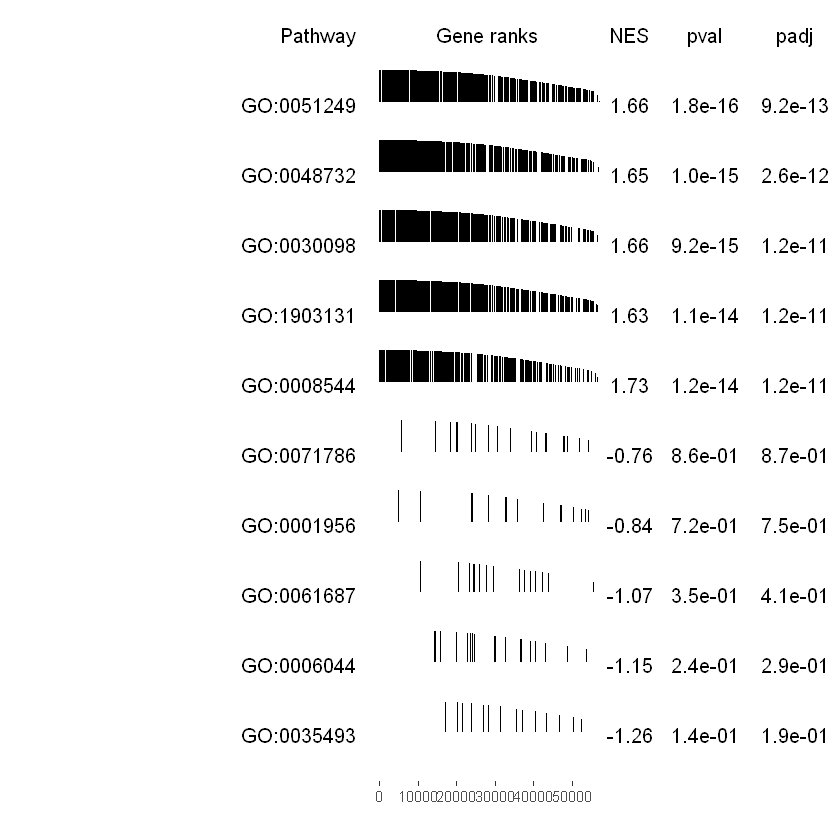

In [31]:
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=5), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=5), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(GO_term_hallmark[topPathways], stats, fgseaRes,
              gseaParam=0.5)

### FGSEA Using KEGG

In [32]:
# Load the pathways into a named list
KEGG_hallmark <- gmtPathways("./data/KEGG_pathways.gmt")

# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(KEGG_hallmark,head)
tmp[1:5]

$hsa00010
[1] "HK3"   "HK1"   "HK2"   "HKDC1" "GCK"   "GPI"  

$hsa00020
[1] "CS"   "ACLY" "ACO2" "ACO1" "IDH1" "IDH2"

$hsa00030
[1] "GPI"  "G6PD" "PGLS" "H6PD" "PGD"  "RPE" 

$hsa00040
[1] "GUSB"    "KL"      "UGT2A1"  "UGT2A3"  "UGT2B17" "UGT2B11"

$hsa00051
[1] "MPI"   "PMM2"  "PMM1"  "GMPPB" "GMPPA" "GMDS"

In [33]:
# Running fgsea
suppressWarnings(fgseaRes <- fgsea(pathways = KEGG_hallmark,
                  stats    = stats,
                  minSize  = 15,
                  maxSize  = 500))

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (62.67% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos"."


In [34]:
head(fgseaRes[order(pval), ][,-8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
hsa05168,2.910448e-13,9.255225e-11,0.9325952,0.3559273,1.593542,468
hsa04060,8.799350e-13,1.399097e-10,0.9214260,0.3884407,1.708131,291
hsa04151,1.244205e-10,1.318857e-08,0.8266573,0.3566070,1.578756,353
hsa04530,2.765729e-09,2.198755e-07,0.7749390,0.4137364,1.764828,164
hsa04510,9.493370e-09,6.037784e-07,0.7477397,0.3850561,1.664239,199
hsa05202,7.812630e-08,4.140694e-06,0.7049757,0.3821628,1.644038,188


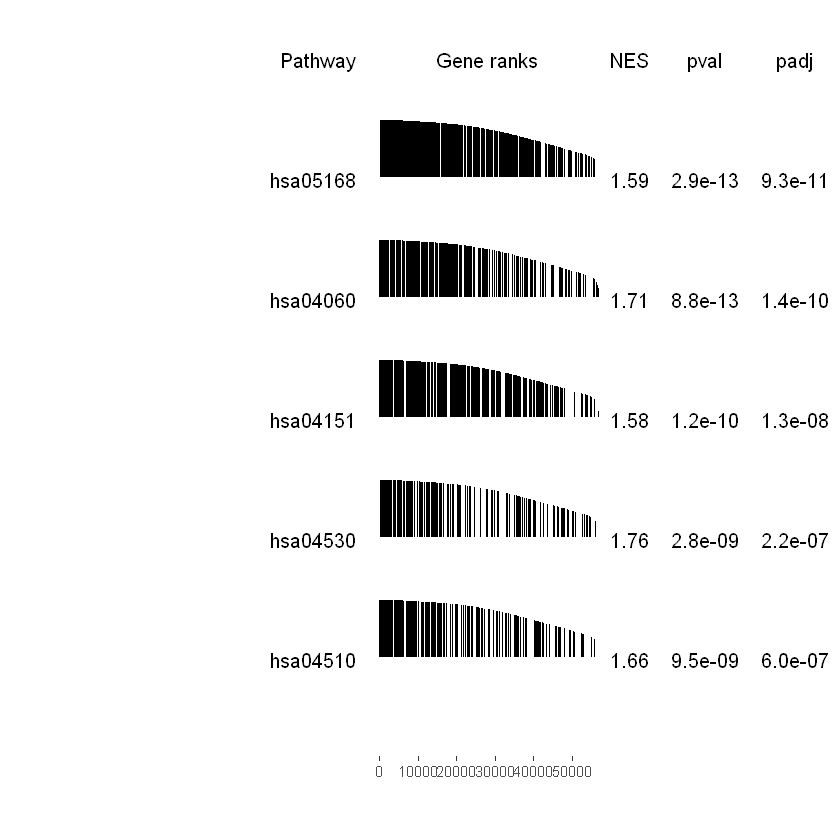

In [35]:
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=5), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=5), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(KEGG_hallmark[topPathways], stats, fgseaRes,
              gseaParam=0.5)

## Gene Set Enrichment Analysis using GSA

This submodule explains Gene Set Analysis (GSA), an Enrichment Analysis, a method that is commonly used to summarize high-dimensional gene expression data sets into sets according to its biological relevance. GSA takes the ranked gene lists from the initial stage of a gene expression analysis and aggregates the genes into sets based on shared biological or functional properties as specified by a reference knowledge base. Such databases often contain phenotype associations, molecular interactions and regulation and are referenced in the analysis of the resultant gene sets to find the relevance of the gene properties to the phenotype of interest.

### GSA Enrichment Analysis procedure starts with Data preparation

In [ ]:
# Install GSA from CRAN
suppressMessages({if (!require("GSA"))
        suppressWarnings(install.packages("GSA"))
})

In [38]:
suppressMessages({
  library(GSA)
})

In [39]:
# Loading expression data with groups
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

In [40]:
expression_data$PROBEID <- rownames(expression_data)

In [41]:
probeIDs <- rownames(expression_data)

In [42]:
suppressMessages({
  annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'SYMBOL'))
})

In [43]:
# Merge DE result  data frame with annotation table
new_expression_data = merge(annotLookup, expression_data, by="PROBEID")

In [44]:
# Remove NA value
new_expression_data <- new_expression_data[!is.na(new_expression_data$SYMBOL),]
# Remove duplicated genes symbol
new_expression_data <-  new_expression_data[!duplicated(new_expression_data$SYMBOL,fromLast=FALSE),]
rownames(new_expression_data) <- new_expression_data$SYMBOL

In [45]:
# Drop PROBEID, GENENAME, and SYMBOL columns
new_expression_data <- new_expression_data[,-c(1:3)]

In [46]:
genenames= rownames(new_expression_data)

### GSA Enrichment analysis using GO terms

In [48]:
genesets = GO_term_hallmark
GSA.obj<-GSA(as.matrix(new_expression_data),as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired")

perm= 10 / 200 
perm= 20 / 200 
perm= 30 / 200 
perm= 40 / 200 
perm= 50 / 200 
perm= 60 / 200 
perm= 70 / 200 
perm= 80 / 200 
perm= 90 / 200 
perm= 100 / 200 
perm= 110 / 200 
perm= 120 / 200 
perm= 130 / 200 
perm= 140 / 200 
perm= 150 / 200 
perm= 160 / 200 
perm= 170 / 200 
perm= 180 / 200 
perm= 190 / 200 
perm= 200 / 200 


In [ ]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj, geneset.names=names(genesets),FDRcut=.5)

A table of the negative gene sets. “Negative” means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. Eg for two classes coded 1,2, lower expression correlates with class 2. For survival data, lower expression correlates with higher risk, i.e shorter survival (Be careful, this can be confusing!

In [ ]:
neg.table <-res$negative
neg.table

A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [ ]:
pos.table <-res$positive
pos.table

In [ ]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(10, genesets, GSA.obj, genenames)

In [ ]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
GSA.plot(GSA.obj, fac=1, FDRcut = 0.5)

### Enrichment analysis using KEGG pathways

In [112]:
genesets = KEGG_hallmark
GSA.obj<-GSA(as.matrix(new_expression_data),as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired")

In [115]:
genenames= rownames(new_expression_data)

In [ ]:
neg.table <-res$negative
head(neg.table)

where:
+ x: Data x: p by n matrix of features (expression values), one observation per column (missing values allowed); y: n-vector of outcome measurements
+ y: Vector of response values: 1,2 for two class problem, or 1,2,3 ... for multiclass
problem, or real numbers for quantitative or survival problems
+ genesets: Gene set collection (a list)
+ genenames: Vector of genenames in expression dataset
+ method: Method for summarizing a gene set: "maxmean" (default), "mean" or "absmean"
+ resp.type: Problem type: "quantitative" for a continuous parameter; "Two class unpaired"
; "Survival" for censored survival outcome; "Multiclass" : more than 2 groups,
coded 1,2,3...; "Two class paired" for paired outcomes, coded -1,1 (first pair),
-2,2 (second pair), etc
+ censoring.status:
Vector of censoring status values for survival problems, 1 mean death or failure,
0 means censored
+ random.seed: Optional initial seed for random number generator (integer)
+ knn.neighbors: Number of nearest neighbors to use for imputation of missing features values
+ s0: Exchangeability factor for denominator of test statistic; Default is automatic
choice
+ s0.perc: Percentile of standard deviation values to use for s0; default is automatic choice;
-1 means s0=0 (different from s0.perc=0, meaning s0=zeroeth percentile of standard deviation values= min of sd values)

In [ ]:
pos.table <-res$positive
head(pos.table)

### GSA Enrichment analysis using GO terms

In [116]:
genesets = GO_term_hallmark
GSA.obj<-GSA(as.matrix(new_expression_data),as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired", nperms=100)

In [ ]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj, geneset.names=names(genesets),FDRcut=.5)

A table of the negative gene sets. “Negative” means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. Eg for two classes coded 1,2, lower expression correlates with class 2. For survival data, lower expression correlates with higher risk, i.e shorter survival (Be careful, this can be confusing!

In [ ]:
neg.table <-res$negative
neg.table

A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [ ]:
pos.table <-res$positive
pos.table

In [ ]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(10, genesets, GSA.obj, genenames)

In [ ]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
GSA.plot(GSA.obj, fac=1, FDRcut = 0.5)

### Enrichment analysis using KEGG pathways

In [130]:
genesets = KEGG_hallmark
GSA.obj<-GSA(as.matrix(new_expression_data),as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired", nperms=100)

perm= 10 / 100 
perm= 20 / 100 
perm= 30 / 100 
perm= 40 / 100 
perm= 50 / 100 
perm= 60 / 100 
perm= 70 / 100 
perm= 80 / 100 
perm= 90 / 100 
perm= 100 / 100 


In [132]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj, geneset.names=names(genesets),FDRcut=.5)

A table of the negative gene sets. "Negative" means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. Eg for two classes coded 1,2, lower expression correlates with class 2. For survival data, lower expression correlates with higher risk, i.e shorter survival (Be careful, this can be confusing!)


In [133]:
neg.table <-res$negative
neg.table

Gene_set,Gene_set_name,Score,p-value,FDR
15,hsa00190,-1.0545,0,0
81,hsa00970,-0.8368,0,0
163,hsa04260,-0.6791,0,0
246,hsa04932,-0.6198,0,0
271,hsa05016,-0.7231,0,0
273,hsa05020,-0.6949,0,0
274,hsa05022,-0.5237,0,0
208,hsa04714,-0.5285,0.01,0.2658
268,hsa05010,-0.5025,0.01,0.2658
269,hsa05012,-0.7434,0.01,0.2658


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [134]:
pos.table <-res$positive
pos.table

Gene_set,Gene_set_name,Score,p-value,FDR
179,hsa04520,0.4948,0,0
200,hsa04662,0.3778,0,0
223,hsa04810,0.1843,0,0
185,hsa04612,0.5797,0.01,0.3544
194,hsa04640,0.5286,0.01,0.3544
197,hsa04658,0.4347,0.01,0.3544
198,hsa04659,0.3344,0.01,0.3544
343,hsa05332,0.891,0.01,0.3544
349,hsa05416,0.8136,0.01,0.3544
7,hsa00053,0.7591,0.02,0.4908


In [137]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(10, genesets, GSA.obj, genenames)


Gene,Score
ALDH9A1,2.707
HADHA,1.725
ACADVL,1.609
ADH1B,1.513
HADHB,1.175
ACAA1,0.79
ALDH2,0.768
ACSBG1,0.73
ALDH3A2,0.726
ACSL1,0.662


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"2 x values <= 0 omitted from logarithmic plot"


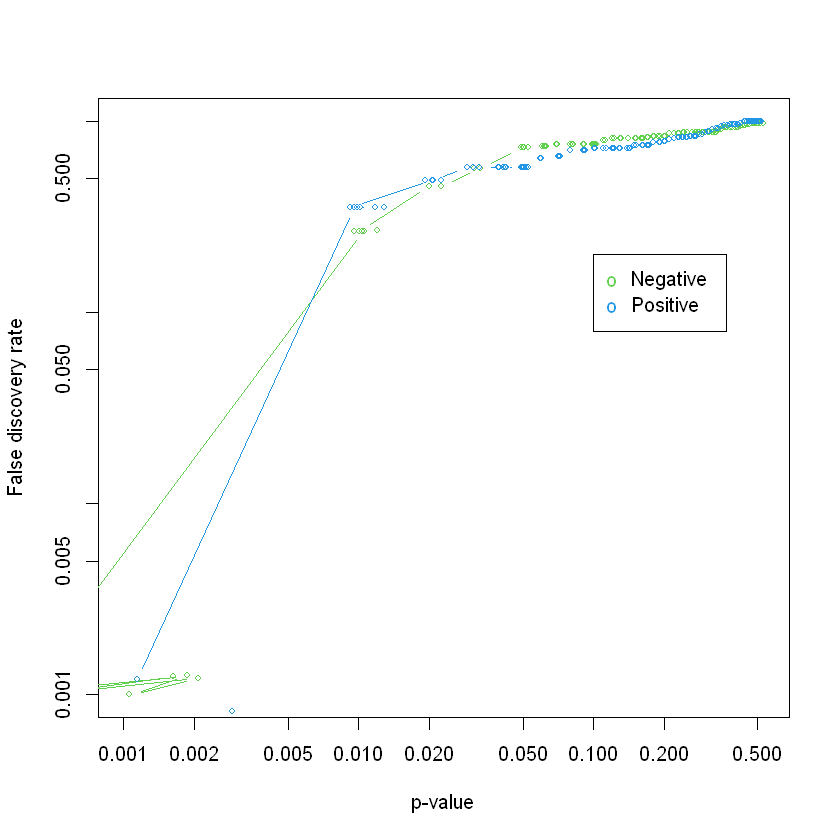

In [138]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
GSA.plot(GSA.obj, fac=1, FDRcut = 0.5)
